In [1]:
# 推測統計のためのライブラリ、データ準備
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats, integrate
from scipy.optimize import minimize_scalar

%precision 3
%matplotlib inline

In [2]:
# 期待値、分散などをあらかじめ定義しておく
linestyles = ['-', '--', ':']

def E(X,  g=lambda x: x):
    x_range, f = X
    def integrand(x):
        return g(x) * f(x)
    return integrate.quad(integrand, -np.inf, np.inf)[0]

def V(X, g=lambda x: x):
    x_range, f = X
    mean = E(X, g)
    def integrand(x):
        return (g(x) - mean) ** 2 * f(x)
    return integrate.quad(integrand, -np.inf, np.inf)[0]

def check_prob(X):
    x_range, f = X
    f_min = minimize_scalar(f).fun
    assert f_min >= 0, '密度関数が負の値をとります'
    prob_sum = np.round(integrate.quad(f, -np.inf, np.inf)[0], 6)
    assert prob_sum == 1, f'確率の和が{prob_sum}になりました'
    print(f'期待値は{E(X): .3f}')
    print(f'分散は{V(X): .3f}')
    
def plot_prob(X, x_min, x_max):
    x_range, f = X
    def F(x):
        return integrate.quad(f, -np.inf, x)[0]
    
    xs = np.linspace(x_min, x_max, 100)
    
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.plot(xs, [f(x) for x in xs],
                   label='f(x)', color='gray')
    ax.plot(xs, [F(x) for x in xs],
                   label='F(x)', ls='--', color='gray')
    
    ax.legend()
    plt.show()

In [3]:
# 正規分布の実装(Numpy)
#  平均値を中心にして分布が左右均等
def N(mu, sigma):
    x_range = [-np.inf, np.inf]
    def f(x):
        return 1 / np.sqrt(2 * np.pi * sigma**2) *\
                            np.exp(-(x-mu)**2 / (2 * sigma**2))
    return x_range, f

In [4]:
#N(2, 0.5^2)に従う確率変数Xを作成
mu, sigma = 2, 0.5
X = N(mu, sigma)

In [5]:
check_prob(X)

期待値は 2.000
分散は 0.250


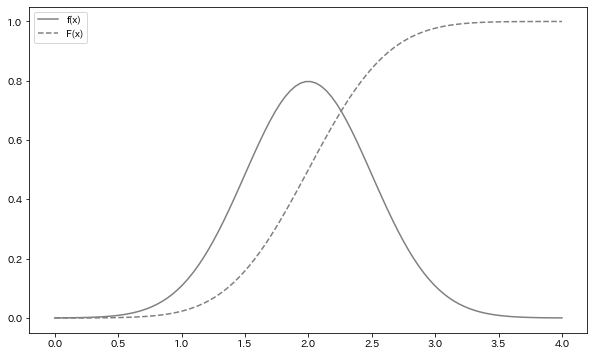

In [6]:
# 密度関数と分布関数を0から4の区間で図示
plot_prob(X, 0, 4)

In [7]:
# 正規分布の実装(Scipy)
rv = stats.norm(2, 0.5)

In [8]:
rv.mean(), rv.var()

(2.0, 0.25)

In [9]:
# 密度関数を求める
rv.pdf(2)

0.7978845608028654

In [10]:
# 分布関数を求める
rv.cdf(1.7)

0.27425311775007355

In [11]:
# 上側100α%点を求める
#  →P(X=>x) = αを満たす様な点
# →領域の右端からの面積がαになるような点
rv.isf(0.3)

2.2622002563540207

In [12]:
# 100α%点を求める
# →P(a<=X<=b) = αを満たす様な点
# →中央から左右に同じ領域だけ塗りつぶした時に
# →その面積の総和がαとなるような点
rv.interval(0.9)

(1.1775731865242636, 2.822426813475736)

In [13]:
rv.isf(0.95), rv.isf(0.05)

(1.1775731865242638, 2.8224268134757367)

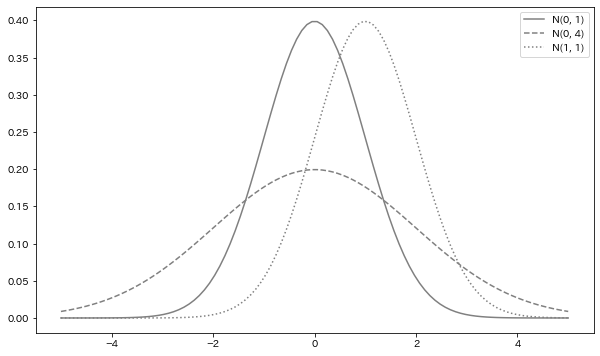

In [14]:
# パラメタによって正規分布の形状がどの様に変化するか確認
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

xs = np.linspace(-5, 5, 100)
params = [(0, 1), (0, 2), (1, 1)]
for param, ls in zip(params, linestyles):
    mu, sigma = param
    rv = stats.norm(mu, sigma)
    ax.plot(xs, rv.pdf(xs),
           label=f'N({mu}, {sigma**2})', ls=ls, color='gray')
ax.legend()

plt.show()

In [15]:
# 指数分布
# →単位時間当たり平均λ回発生する事象の発生間隔が従う確率分布
# 単位時間当たりに何回事象が発生するか→ポアソン分布
# 事象に発生間隔→指数分布

# 指数分布の実装(Numpy)
def Ex(lam):
    x_range = [0, np.inf]
    def f(x):
        if x>= 0:
            return lam * np.exp(-lam * x)
        else:
            return 0
    return x_range, f

In [16]:
# Ex(3)に従う確率変数
lam = 3
X = Ex(lam)

In [17]:
check_prob(X)

期待値は 0.333
分散は 0.111


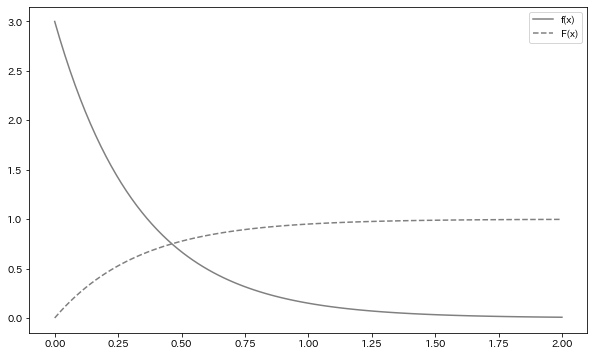

In [18]:
# 密度関数と分布関数を0〜2の区間で図示

plot_prob(X, 0, 2)

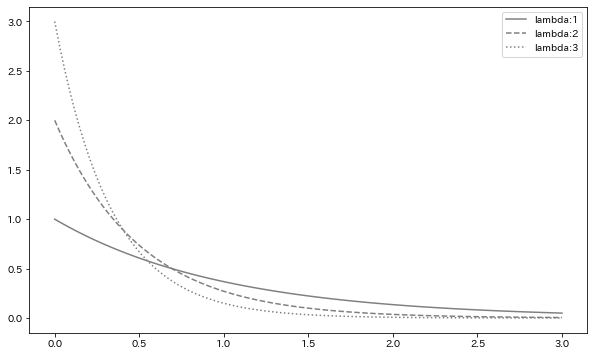

In [19]:
# パラメタを変化させたときの指数分布の変化を確認する
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

xs = np.linspace(0, 3, 100)
for lam, ls in zip([1, 2, 3], linestyles):
    rv = stats.expon(scale=1/lam)
    ax.plot(xs, rv.pdf(xs),
           label=f'lambda:{lam}', ls=ls, color='gray')
ax.legend()
plt.show()

In [20]:
#  カイ2乗分布
# Z1、Z2、Z3......Znが互いに独立にN(0, 1)に従っているとき、その二乗和
# の確率分布を自由度nのカイ2乗分布という
n = 10
rv = stats.norm()
sample_size = int(1e6)
# 　標準正規分布から10 × 100万のサイズで無作為抽出
Zs_sample = rv.rvs((n, sample_size))
# axis=0の方向で総和をとり、標準正規分布の二乗和の標本データをつくる
chi2_sample = np.sum(Zs_sample**2, axis=0)

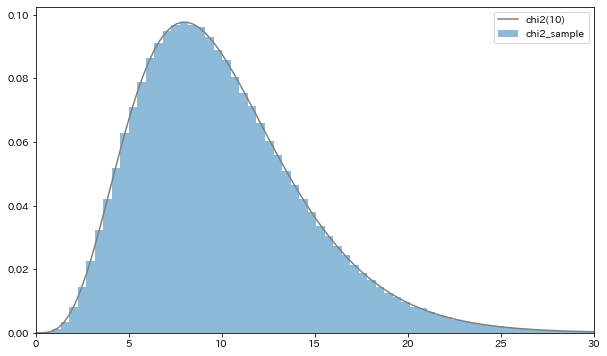

In [21]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

rv_true = stats.chi2(n)
xs = np.linspace(0, 30,100)
ax.hist(chi2_sample, bins=100, density=True,
             alpha=0.5, label='chi2_sample')
ax.plot(xs, rv_true.pdf(xs), label=f'chi2({n})', color='gray')

ax.legend()
ax.set_xlim(0, 30)
plt.show()

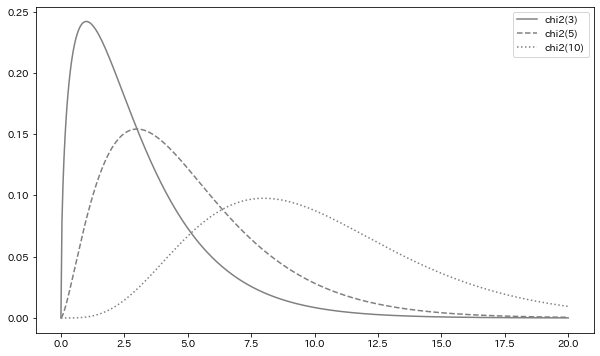

In [22]:
# 自由度nを変化させた時のカイ二乗分布
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

xs = np.linspace(0, 20, 500)
for n, ls in zip([3, 5, 10], linestyles):
    rv = stats.chi2(n)
    ax.plot(xs, rv.pdf(xs),
           label=f'chi2({n})', ls=ls, color='gray')
    
ax.legend()
plt.show()

In [23]:
# カイ二乗分布の上側5%点
rv = stats.chi2(5)
rv.isf(0.05)

11.070497693516355

In [24]:
# t分布
# 確率変数Z、Yは互いに独立で、Zは標準正規分布N(0, 1)に、
# Yは自由度nのカイ二乗分布χ^2(n)に従うとき、
# t = Z / (Y/n)^0.5
# の確率分布を自由度nのt分布という
n = 10
rv1 = stats.norm()
rv2 = stats.chi2(n)

sample_size = int(1e6)
Z_sample = rv1.rvs(sample_size)
chi2_sample = rv2.rvs(sample_size)

t_sample = Z_sample / np.sqrt(chi2_sample / n)

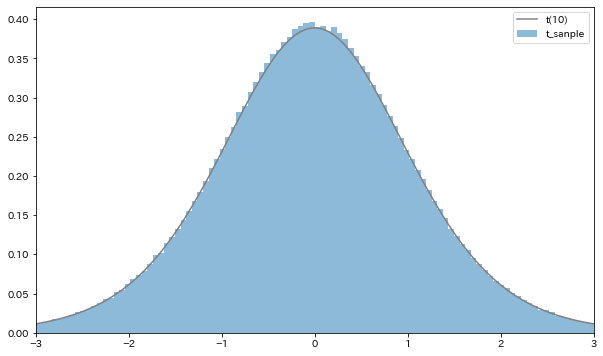

In [26]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

rv = stats.t(n)
xs = np.linspace(-3, 3, 100)
ax.hist(t_sample, bins=100, range=(-3, 3),
       density=True, alpha=0.5, label='t_sanple')
ax.plot(xs, rv.pdf(xs), label=f't({n})', color='gray')

ax.legend()
ax.set_xlim(-3, 3)
plt.show()

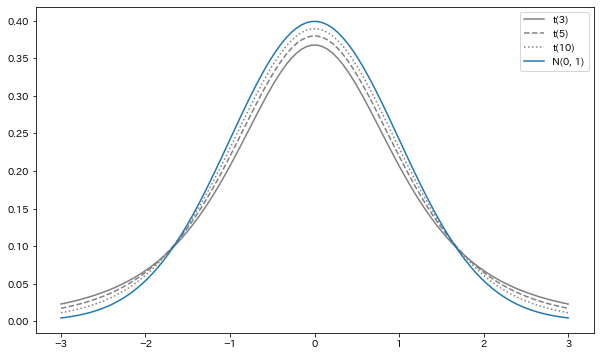

In [29]:
# t分布が自由度nによってどのような分布になるかを確認
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

xs = np.linspace(-3, 3, 100)
for n, ls in zip([3, 5, 10], linestyles):
    rv = stats.t(n)
    ax.plot(xs, rv.pdf(xs),
           label=f't({n})', ls=ls, color='gray')
rv = stats.norm()
ax.plot(xs, rv.pdf(xs), label='N(0, 1)')

ax.legend()
plt.show()

In [30]:
# 自由度5の上側5%点
rv = stats.t(5)
rv.isf(0.05)

2.0150483726691575

In [31]:
# F分布
# →互いに独立な2つのカイ2乗分布によって定義される
# 確率変数Y1、Y2が互いに独立で、それぞれY1〜Χ^2(n1)、Y2〜Χ^2(n2)
# に従うとき、F = (Y1/n1) / (Y2/n2)
# の確率分布を自由度n1、n2のF分布(n1、n2)という。
n1 = 5
n2 = 10
rv1 = stats.chi2(n1)
rv2 = stats.chi2(n2)

sample_size = int(1e6)
sample1 = rv1.rvs(sample_size)
sample2 = rv2.rvs(sample_size)

f_sample = (sample1/n1) / (sample2/n2)

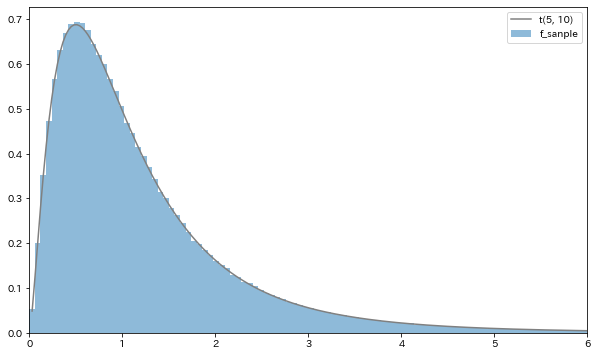

In [32]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

rv = stats.f(n1, n2)
xs = np.linspace(0, 6, 200)[1:]
ax.hist(f_sample, bins=100, range=(0, 6),
       density=True, alpha=0.5, label='f_sanple')
ax.plot(xs, rv.pdf(xs), label=f't({n1}, {n2})', color='gray')

ax.legend()
ax.set_xlim(0, 6)
plt.show()

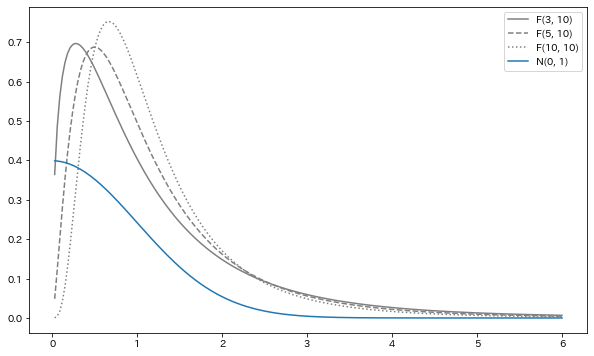

In [33]:
# F分布が自由度nによってどのような分布になるかを確認
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

xs = np.linspace(0, 6, 200)[1:]
for n1, ls in zip([3, 5, 10], linestyles):
    rv = stats.f(n1, 10)
    ax.plot(xs, rv.pdf(xs),
           label=f'F({n1}, 10)', ls=ls, color='gray')
rv = stats.norm()
ax.plot(xs, rv.pdf(xs), label='N(0, 1)')

ax.legend()
plt.show()